In [1]:
import pandas as pd 
import numpy as np 

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
cmap = sns.diverging_palette(220, 10, as_cmap=True)

from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import plot_importance, XGBClassifier, XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor 
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats


import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('../input/perth-house-prices/all_perth_310121.csv')
df.head()

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019\r,6167,-32.193470,115.859554,ATWELL COLLEGE,5.524324,129.0
2,1 Ainsley Court,Camillo,287000,3,1,1.0,719,86,1979.0,22600,Challis Station,1900,06-2015\r,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1.649178,113.0
3,1 Albert Street,Bellevue,255000,2,1,2.0,651,59,1953.0,17900,Midland Station,3600,07-2018\r,6056,-31.900547,116.038009,SWAN VIEW SENIOR HIGH SCHOOL,1.571401,NaN
4,1 Aman Place,Lockridge,325000,4,1,2.0,466,131,1998.0,11200,Bassendean Station,2000,11-2016\r,6054,-31.885790,115.947780,KIARA COLLEGE,1.514922,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33656 entries, 0 to 33655
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           33656 non-null  object 
 1   SUBURB            33656 non-null  object 
 2   PRICE             33656 non-null  int64  
 3   BEDROOMS          33656 non-null  int64  
 4   BATHROOMS         33656 non-null  int64  
 5   GARAGE            31178 non-null  float64
 6   LAND_AREA         33656 non-null  int64  
 7   FLOOR_AREA        33656 non-null  int64  
 8   BUILD_YEAR        30501 non-null  float64
 9   CBD_DIST          33656 non-null  int64  
 10  NEAREST_STN       33656 non-null  object 
 11  NEAREST_STN_DIST  33656 non-null  int64  
 12  DATE_SOLD         33656 non-null  object 
 13  POSTCODE          33656 non-null  int64  
 14  LATITUDE          33656 non-null  float64
 15  LONGITUDE         33656 non-null  float64
 16  NEAREST_SCH       33656 non-null  object

In [4]:
df.drop_duplicates(subset=['ADDRESS'],inplace=True)
df.index=df['ADDRESS']
del df['ADDRESS']
df.head()

,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
ADDRESS,,,,,,,,,,,,,,,,,,
1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN
1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019\r,6167,-32.193470,115.859554,ATWELL COLLEGE,5.524324,129.0
1 Ainsley Court,Camillo,287000,3,1,1.0,719,86,1979.0,22600,Challis Station,1900,06-2015\r,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1.649178,113.0
1 Albert Street,Bellevue,255000,2,1,2.0,651,59,1953.0,17900,Midland Station,3600,07-2018\r,6056,-31.900547,116.038009,SWAN VIEW SENIOR HIGH SCHOOL,1.571401,NaN
1 Aman Place,Lockridge,325000,4,1,2.0,466,131,1998.0,11200,Bassendean Station,2000,11-2016\r,6054,-31.885790,115.947780,KIARA COLLEGE,1.514922,NaN


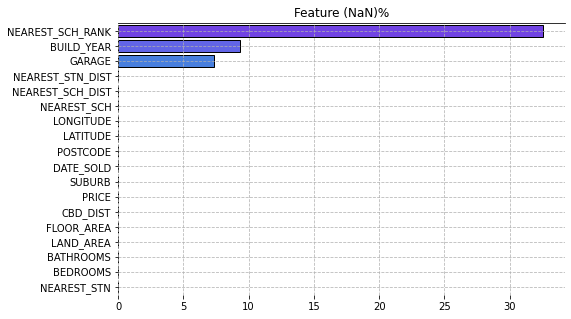

In [5]:
fig, ax = plt.subplots(figsize =(8,5))
nan_val = (df.isnull().sum()/len(df)*100).sort_values(ascending = False)
cmap = sns.color_palette("plasma")
for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_color('black')
ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)
sns.barplot(x=nan_val,y=nan_val.index, edgecolor='k',palette = 'rainbow')
plt.title('Feature (NaN)%');ax.grid(ls='--',alpha = 0.9);plt.show()

In [6]:
print(df.shape)
df['GARAGE']=df['GARAGE'].fillna(0)
df=df.dropna(axis=0,how='any')
print(df.shape)

(33566, 18)
(20625, 18)


In [7]:
df_num=df.select_dtypes(include=['float64','int64'])
df_cat=df.select_dtypes(exclude=['float64','int64'])

In [8]:
print(df_num.columns)
print(df_cat.columns)

Index(['PRICE', 'BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA',
       'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN_DIST', 'POSTCODE', 'LATITUDE',
       'LONGITUDE', 'NEAREST_SCH_DIST', 'NEAREST_SCH_RANK'],
      dtype='object')
Index(['SUBURB', 'NEAREST_STN', 'DATE_SOLD', 'NEAREST_SCH'], dtype='object')


In [9]:
df_cat['DATE_SOLD'].str.replace("\\r","")
df_num[['SOLD_MONTH','SOLD_YEAR']]=df_cat['DATE_SOLD'].str.split('-',1,expand=True).astype('int64')
df_cat.drop(['DATE_SOLD'],axis=1,inplace=True)
df_num['BUILD_YEAR']=df_num['BUILD_YEAR'].apply(np.int64)

In [10]:
df_perth=pd.concat([df_num,df_cat],axis=1)
df_perth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20625 entries, 1 Addis Way to 9C Gold Street
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PRICE             20625 non-null  int64  
 1   BEDROOMS          20625 non-null  int64  
 2   BATHROOMS         20625 non-null  int64  
 3   GARAGE            20625 non-null  float64
 4   LAND_AREA         20625 non-null  int64  
 5   FLOOR_AREA        20625 non-null  int64  
 6   BUILD_YEAR        20625 non-null  int64  
 7   CBD_DIST          20625 non-null  int64  
 8   NEAREST_STN_DIST  20625 non-null  int64  
 9   POSTCODE          20625 non-null  int64  
 10  LATITUDE          20625 non-null  float64
 11  LONGITUDE         20625 non-null  float64
 12  NEAREST_SCH_DIST  20625 non-null  float64
 13  NEAREST_SCH_RANK  20625 non-null  float64
 14  SOLD_MONTH        20625 non-null  int64  
 15  SOLD_YEAR         20625 non-null  int64  
 16  SUBURB            20625 no

In [11]:
def px_stats(df, n_cols=4, to_plot='box',height=800):
    
    numeric_cols = df_num.columns
    n_rows = -(-len(numeric_cols) // n_cols) 
    row_pos, col_pos = 1, 0
    fig = make_subplots(rows=n_rows, cols=n_cols,subplot_titles=numeric_cols.to_list())
    
    for col in numeric_cols:
        if(to_plot is 'histogram'):
            trace = go.Histogram(x=df_num[col],showlegend=False)
        else:
            trace = getattr(px, to_plot)(df_num[col],x=df_num[col])["data"][0]
            
        if col_pos == n_cols: 
            row_pos += 1
        col_pos = col_pos + 1 if (col_pos < n_cols) else 1
        fig.add_trace(trace, row=row_pos, col=col_pos)

    fig.update_layout(template='plotly_white');fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0})
    
    fig.update_layout(height=height);fig.show()

In [12]:
px_stats(df_perth, to_plot='histogram')

In [13]:
px_stats(df_perth, to_plot='box', height=400)